In [79]:
import geemap
import ee
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Load data and preprocess

#### SOC

In [169]:
path_soc = 'Total_Carbon_per_zone_global_1degreelat_v2_run3.csv'
df_soc = pd.read_csv(path_soc)

In [170]:
# define depth columns
depth_cols = ['0-5cm', '5-15cm', '15-30cm', '30-60cm', '60-100cm', '100-200cm', '200-300cm']
depth_cols_aggregated_dict = {'0-30cm':['0-5cm', '5-15cm', '15-30cm'], '30-100cm':['30-60cm', '60-100cm'], '100-300cm':['100-200cm', '200-300cm']}
depth_cols_aggregated = list(depth_cols_aggregated_dict.keys())

In [171]:
# rename for direct label naming in seaborn
df = df_soc
df_renamed = df_soc.rename(columns={'south':'latitude', 'sum':'Carbon stocks Gt'}).sort_values('latitude', ascending=False)
# add 3rd meter
df_renamed['200-300cm'] = df_renamed['100-200cm']

In [172]:
# add aggregated depths
for key in depth_cols_aggregated:
    df_renamed[key] = df_renamed[depth_cols_aggregated_dict[key]].sum(axis=1)

In [173]:
# change to Gt
df_renamed[depth_cols + depth_cols_aggregated] *= 1e-9

#### Area

In [296]:
path_area = 'land_area_km2_per_latitude_01grid.csv'
df_area = pd.read_csv(path_area)
df_area = df_area.rename(columns={'south':'latitude'})[['latitude', 'land_area']]
df_area['latitude'] = df_area['latitude'].astype(int)

#### Yedoma

In [229]:
path_yedoma = 'yedoma_area_km2_per_latitude_01grid.csv'
df_yedoma = pd.read_csv(path_yedoma)
df_yedoma['latitude'] = df_yedoma['latitude'].astype(int)
df_yedoma = df_yedoma[['latitude','yedoma_area']]

convert yedoma toarea to carbon:

area * 1e6 (to m²) * 12.5904247 (kg) * 1e-12 (gT)

In [230]:
yedoma_carbon = 12.5904247
yedoma_depth = 14
df_yedoma['yedoma_soc_gt'] = df_yedoma['yedoma_area'] * 1e6 * yedoma_carbon*yedoma_depth * 1e-12

#### Permafrost

In [297]:
path_permafrost = 'pfextent_area_km2_per_latitude_01grid.csv'
df_permafrost = pd.read_csv(path_permafrost)
df_permafrost['latitude'] = df_permafrost['latitude'].astype(int)
df_permafrost = df_permafrost[['latitude','EXTENT', 'pf_area']]

# separate by pf extent
df_list = [df_permafrost[df_permafrost['EXTENT'] ==pfe].rename(columns={'pf_area':f'{pfe} PF Area'}).drop(columns=['EXTENT']).set_index('latitude') for pfe in ['C', 'D', 'S', 'I']]

# merge
df_permafrost_final = pd.concat(df_list, axis=1)

In [298]:
pf_cols = list(df_permafrost_final.columns)

### Load subsea

In [441]:
path_subsea = 'SubseaPermafrost_OC_Gt_per_lat_v2.csv'
df_subsea = pd.read_csv(path_subsea, delimiter='\t')

cols = [col.strip() for col in df_subsea.columns]
df_subsea.columns = cols

df_subsea = df_subsea.rename(columns={'Lat':'latitude', 'OC_Gt_per_deg':'subsea_total', 
                          'OC_Gt_per_deg_0to3m':'subsea 0-3m', 
                          'OC_Gt_per_deg_3to25m':'subsea 3-25m', 
                          'OC_Gt_per_deg_25andDeeper':'subsea 25m plus'})

df_subsea = df_subsea.set_index('latitude')

### Preprocess SOC

### Merge files

In [300]:
df_final = df_renamed.set_index('latitude').join(df_area.set_index('latitude')).join(df_yedoma.set_index('latitude')['yedoma_soc_gt']).join(df_permafrost_final).sort_values(by='latitude').reset_index(drop=False)

In [442]:
df_merged = df_renamed.set_index('latitude').join(df_area.set_index('latitude'))\
.join(df_yedoma.set_index('latitude')['yedoma_soc_gt'])\
.join(df_permafrost_final)\
.join(df_subsea)\
.sort_values(by='latitude').reset_index(drop=False)

In [443]:
cols = depth_cols + depth_cols_aggregated + ['land_area', 'latitude'] + ['yedoma_soc_gt'] + pf_cols + list(df_subsea.columns)

In [444]:
df_final = df_merged[cols]

In [445]:
df_final.to_csv('carbon_stocks_cleaned_v4.csv')

In [451]:
print('Soil Carbon total Gt:', df_final[depth_cols].sum().sum())
print('Yedoma Soil Carbon total Gt:', df_final['yedoma_soc_gt'].sum())
print('Total Land Area Mkm²:', df_final['land_area'].sum() * 1e-6)
print('Continuous PF Area Mkm²:', df_final['C PF Area'].sum() * 1e-6)
print('Discontinuous PF Area Mkm²:', df_final['D PF Area'].sum() * 1e-6)
print('Sporadic PF Area Mkm²:', df_final['S PF Area'].sum() * 1e-6)
print('Isolated PF Area Mkm²:', df_final['I PF Area'].sum() * 1e-6)
print('Subsea PF Carbon:', df_final['subsea_total'].sum())
print('Subsea PF Carbon 0-3m:', df_final['subsea 0-3m'].sum())
print('Subsea PF Carbon 3-25m:', df_final['subsea 3-25m'].sum())

Soil Carbon total Gt: 1524.1824061385569
Yedoma Soil Carbon total Gt: 455.96920142042904
Total Land Area Mkm²: 147.03774442197715
Continuous PF Area Mkm²: 10.974452099739993
Discontinuous PF Area Mkm²: 4.42054657131792
Sporadic PF Area Mkm²: 3.969377806321472
Isolated PF Area Mkm²: 3.8901797915413
Subsea PF Carbon: 2821.58
Subsea PF Carbon 0-3m: 92.66
Subsea PF Carbon 3-25m: 1217.14


## Plotting

In [453]:
df_final.columns

Index(['0-5cm', '5-15cm', '15-30cm', '30-60cm', '60-100cm', '100-200cm',
       '200-300cm', '0-30cm', '30-100cm', '100-300cm', 'land_area', 'latitude',
       'yedoma_soc_gt', 'C PF Area', 'D PF Area', 'S PF Area', 'I PF Area',
       'subsea_total', 'subsea 0-3m', 'subsea 3-25m', 'subsea 25m plus'],
      dtype='object')

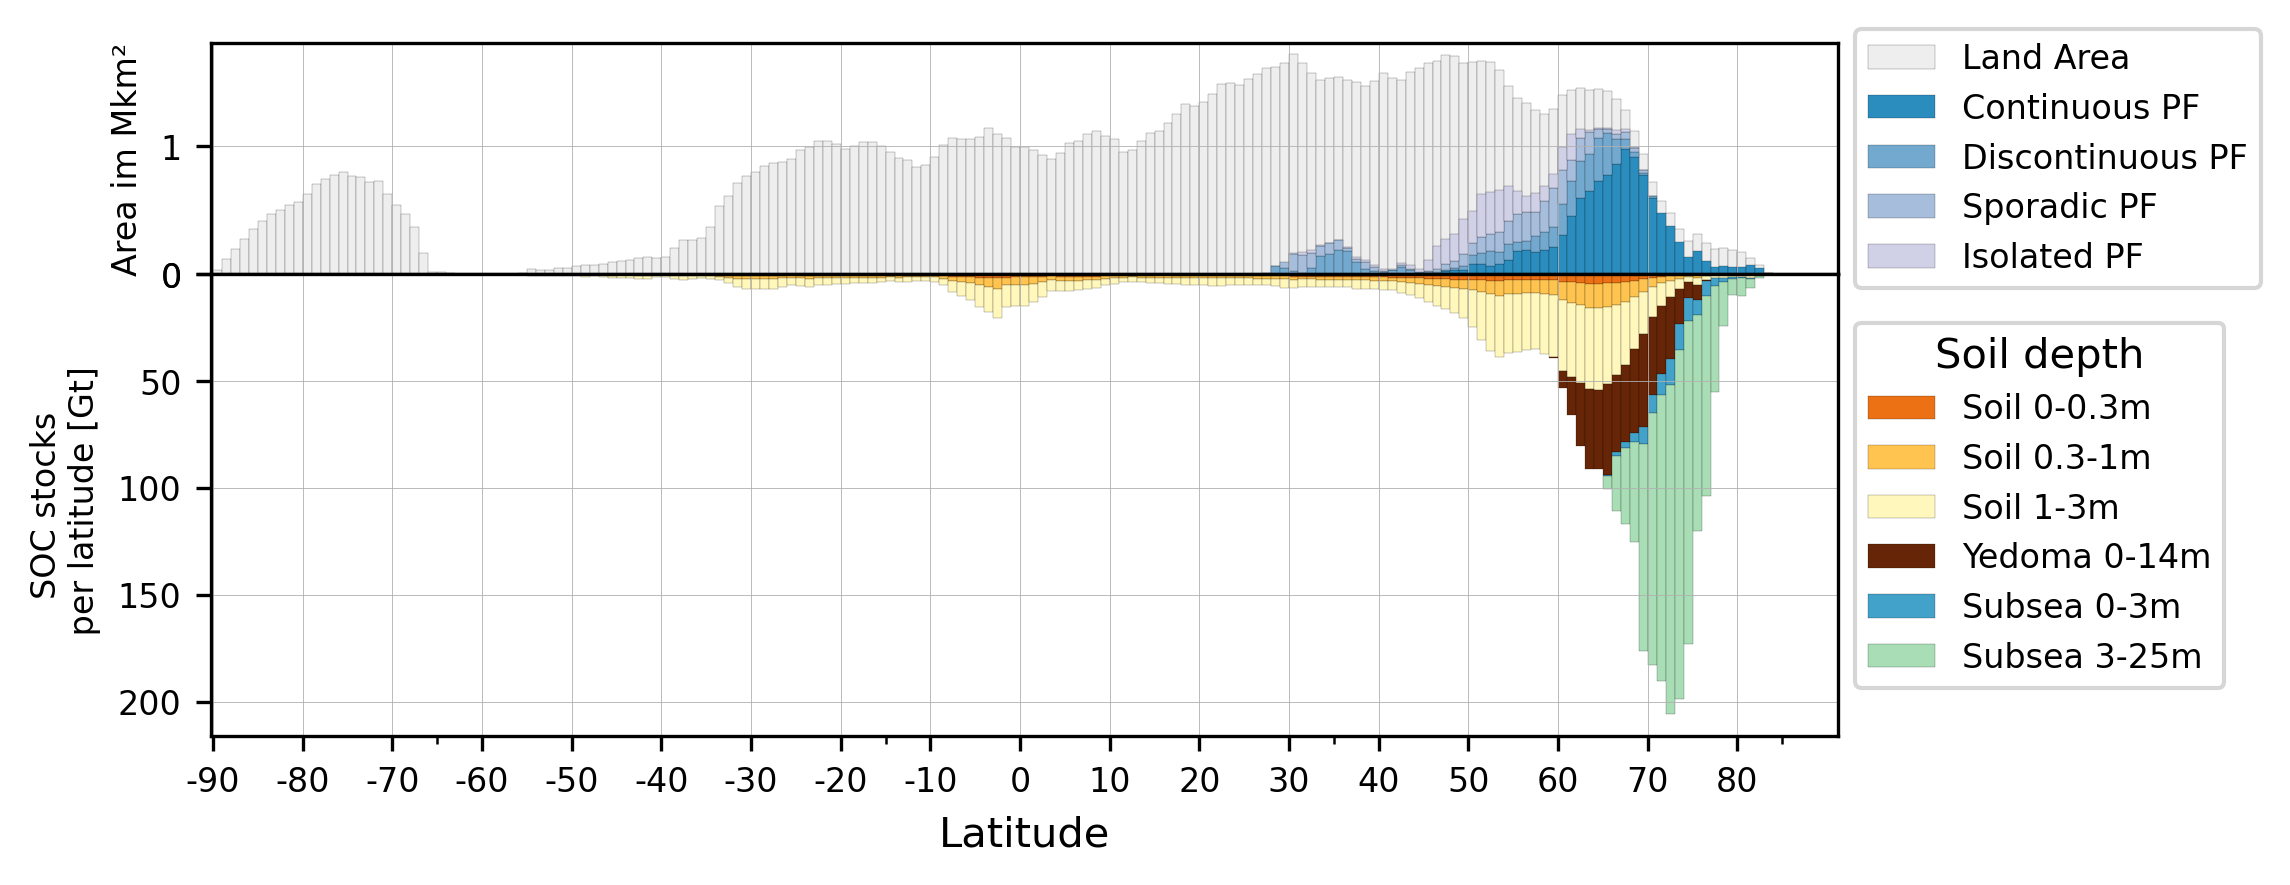

In [461]:
# Define your custom colors
colors_soil = ['#ec7014', '#fec44f', '#fff7bc', '#662506', '#43a2ca', '#a8ddb5']
colors_pf = ['#2b8cbe', '#74a9cf', '#a6bddb', '#d0d1e6']

plot_cols_soil = ['0-30cm', '30-100cm', '100-300cm', 'yedoma_soc_gt', 'subsea 0-3m', 'subsea 3-25m']
legend_labels_soil = ['Soil 0-0.3m', 'Soil 0.3-1m', 'Soil 1-3m', 'Yedoma 0-14m', 'Subsea 0-3m', 'Subsea 3-25m']
# viz params
lw_bars = 0.05
label_size=8
# transform to Mkm²
plot_data = df_final.copy()
plot_data[['land_area', 'C PF Area', 'D PF Area', 'S PF Area', 'I PF Area']]*=1e-6


# Create your plot
fig, (ax2, ax) = plt.subplots(nrows=2, sharex=True, figsize=(7,3), dpi=300, height_ratios=(1,2))
#fig, ax = plt.subplots(figsize=(8,2), dpi=300)
ax = plot_data.plot(kind='bar', stacked=True, x='latitude', y=plot_cols_soil,
                     width=1, color=colors_soil, edgecolor='black', lw=lw_bars, rot=0, align='edge', ax=ax, fontsize=label_size)

ax2 = plot_data.plot(kind='bar', stacked=True, x='latitude', y='land_area',
                     width=1, color='#eeeeee', edgecolor='black', lw=lw_bars, rot=0, align='edge', ax=ax2, fontsize=label_size)
ax2 = plot_data.plot(kind='bar', stacked=True, x='latitude', y=pf_cols,
                     width=1, color=colors_pf, edgecolor='black', lw=lw_bars, rot=0, align='edge', ax=ax2, fontsize=label_size)

ax.invert_yaxis()
ax.set_ylabel('SOC stocks\n per latitude [Gt]', fontsize=label_size)
ax.set_xlabel('Latitude')
ax.grid(lw=0.2)
ax.set_xticks(np.arange(0,180,10))
# legend
ax.legend(legend_labels_soil, title='Soil depth', loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=label_size)

ax2.set_ylabel('Area im Mkm²', fontsize=label_size)
ax2.set_xlabel('')
ax2.grid(lw=0.2)
legend_labels_pf = ['Land Area', 'Continuous PF', 'Discontinuous PF', 'Sporadic PF', 'Isolated PF']
ax2.legend(legend_labels_pf, title=None, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=label_size)

plt.subplots_adjust(hspace=0)
